# RandomForest 회귀 분석 과제 (2주차 기초세션)

중고차 가격 데이터를 바탕으로 랜덤포레스트 회귀분석을 실시하고, CV를 통한 최적의 하이퍼파라미터를 구한 다음 최적 모델의 변수 중요도를 계산

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
df = pd.read_table("usedcar.csv", sep=',')

In [25]:
df.head()

,Price,Odometer,Color
0,14636,37388,white
1,14122,44758,white
2,14470,45854,white
3,15072,40149,white
4,14802,40237,white


In [26]:
# Categorical data info
df["Color"].value_counts()

white     37
other     33
silver    30
Name: Color, dtype: int64

## 전처리

In [27]:
# Data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     100 non-null    int64 
 1   Odometer  100 non-null    int64 
 2   Color     100 non-null    object
dtypes: int64(2), object(1)
memory usage: 2.5+ KB


\
총 100개의 데이터로 이루어져 있으며 널 값이 존재하지 않는다.
- Target: Price
- Feature: Odometer(int64), Color(Object)

In [28]:
# 범주형 데이터 더미 처리
df = pd.get_dummies(df)
df

,Price,Odometer,Color_other,Color_silver,Color_white
0,14636,37388,0,0,1
1,14122,44758,0,0,1
2,14470,45854,0,0,1
3,15072,40149,0,0,1
4,14802,40237,0,0,1
...,...,...,...,...,...
95,14320,38636,1,0,0
96,14244,39198,1,0,0
97,14296,42581,1,0,0
98,15050,31372,1,0,0


## x(feature)와 y(target)값 분리

In [44]:
# Feature 변수들
df_x = df.iloc[:,1:]
df_x

,Odometer,Color_other,Color_silver,Color_white
0,37388,0,0,1
1,44758,0,0,1
2,45854,0,0,1
3,40149,0,0,1
4,40237,0,0,1
...,...,...,...,...
95,38636,1,0,0
96,39198,1,0,0
97,42581,1,0,0
98,31372,1,0,0


In [47]:
# Target 값인 Price
df_y = df['Price']
df_y

0     14636
1     14122
2     14470
3     15072
4     14802
      ...  
95    14320
96    14244
97    14296
98    15050
99    14848
Name: Price, Length: 100, dtype: int64

## test와 training set 분리

In [69]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.25, random_state = 42)

In [88]:
print('Training Features Shape:', X_train.shape)
print('Training Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_train.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (75, 4)
Training Features Shape: (25, 4)
Testing Labels Shape: (75,)
Testing Labels Shape: (25,)


## 모델링

In [89]:
# 별도의 튜닝 없이 우선 모델링 해본다
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(X_train, y_train);

In [90]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)

# Calculate the absolute errors
errors = abs(predictions - y_test)

In [91]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 98.69 %.


운이 좋게도 별도의 파라미너 튜닝 없이도 정확도가 상당히 높게 나온 것으로 보아 효율적인 모델을 생성하였다.\
하지만 연습으로 CV까지 진행해서 최적 파라미터를 살펴보겠다.

## 평가 및 튜닝

In [92]:
from sklearn import metrics
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV

- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

In [94]:
np.random.seed(0)
scores = cross_validate(rf, df_x, df_y, cv=10, scoring="neg_mean_absolute_error")

In [95]:
scores

{'fit_time': array([1.19631791, 0.93323398, 0.92823601, 0.91134429, 0.92834687,
        0.91204309, 0.91190004, 0.9185679 , 0.9227159 , 0.96613693]),
 'score_time': array([0.05762196, 0.05353308, 0.05136323, 0.05158687, 0.05132318,
        0.05374885, 0.05080318, 0.0505228 , 0.04966807, 0.05062127]),
 'test_score': array([-329.0468, -151.7182, -255.408 , -271.5334, -241.8786, -196.2356,
        -189.1496, -213.9112, -212.2952, -310.2606])}

In [96]:
np.random.seed(0)
hyperparamters = {'n_estimators':[50,100,200],
                  'max_depth':[2,3,4,5,6], 
                  'min_samples_split':[4,5,6]} #hyperparameter를 dict type으로 넣기
GridCV = GridSearchCV(estimator=rf, param_grid=hyperparamters, cv=5, verbose=1) 
GridCV.fit(df_x, df_y)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:   28.5s finished


GridSearchCV(cv=5,
             estimator=RandomForestRegressor(n_estimators=1000,
                                             random_state=42),
             param_grid={'max_depth': [2, 3, 4, 5, 6],
                         'min_samples_split': [4, 5, 6],
                         'n_estimators': [50, 100, 200]},
             verbose=1)

In [97]:
# 최적 파라미터
GridCV.best_params_

{'max_depth': 3, 'min_samples_split': 4, 'n_estimators': 200}

In [106]:
# 최적 파라미터로 튜닝 후 다시 모델 생성
rf2 = RandomForestRegressor(max_depth= 3, min_samples_split=4, n_estimators = 200)
rf2.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, min_samples_split=4, n_estimators=200)

In [107]:
# Use the forest's predict method on the test data
predictions = rf2.predict(X_test)

# Calculate the absolute errors
errors = abs(predictions - y_test)

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 98.78 %.


최적 파라미터로 튜닝하였더니 튜닝 전의 모델보다 정확도가 0.1% 정도 상승하였다!\
Before tuning : Accuracy: 98.69 %\
After tuning: Accuracy: 98.78 %

## Feature importance (변수 중요도)

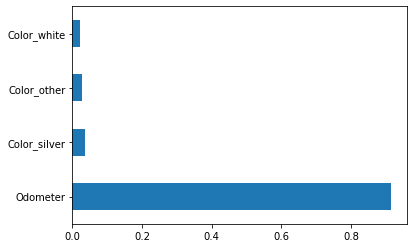

In [108]:
# 튜닝 전 모델의 변수 중요도
rf.fit(df_x, df_y)
default_importances =rf.feature_importances_
indices = np.argsort(default_importances)
feat_importances = pd.Series(rf.feature_importances_, index=df_x.columns)
feat_importances.nlargest(4).plot(kind='barh')
plt.show()

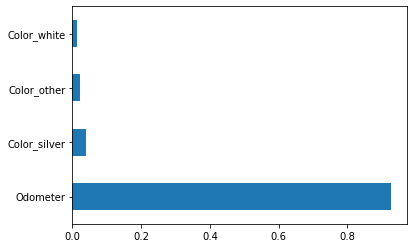

In [109]:
# 튜닝 후 모델의 변수 중요도
rf2.fit(df_x, df_y)
default_importances =rf2.feature_importances_
indices = np.argsort(default_importances)
feat_importances = pd.Series(rf2.feature_importances_, index=df_x.columns)
feat_importances.nlargest(4).plot(kind='barh')
plt.show()

튜닝 후 Odometer의 중요도가 조금 더 상승했다.

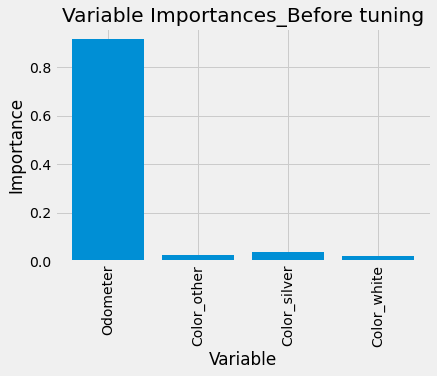

In [112]:
import matplotlib.pyplot as plt
%matplotlib inline

importances = list(rf.feature_importances_)
feature_list = list(df_x.columns)

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); 
plt.xlabel('Variable'); 
plt.title('Variable Importances_Before tuning');

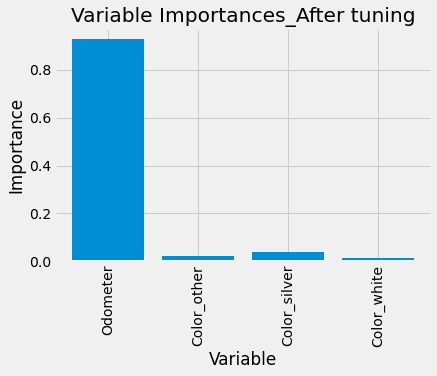

In [113]:
import matplotlib.pyplot as plt
%matplotlib inline

importances = list(rf2.feature_importances_)
feature_list = list(df_x.columns)

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); 
plt.xlabel('Variable'); 
plt.title('Variable Importances_After tuning');